# Training an Object Segmentation Workshop
### By: Aaron Gabrielle C. Dichoso
### From: DLSU - Center of Imaging and Visual Innovations (CIVI)
May 27, 2025

## 1. Importing Libraries

In [1]:
import torch
from torchvision.models.segmentation import fcn_resnet50 #Pytorch built-in model
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

## 2. Notebook configurations
Batch Size: The Number of Images passed to the model during training in one forward pass

Classes: Subset of 12 objects + 1 background class from the standard MSCOCO classes

["dog", "cat", "person", "chair", "mouse", "remote", "keyboard", "cell phone", "cup", "fork", "knife", "spoon"]

Epochs: Number of Iterations that the training images will be passed to the model.

Learning Rate: Affects the strength of adjustments applied to the model during training.

Device: Use CUDA if available, else use the CPU

In [2]:
BATCH_SIZE = 4
NUM_CLASSES = 12 + 1
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

COCO_PATH = './dataset/'
TRAIN_IMG_DIR = os.path.join(COCO_PATH, 'coco_sample/train')
TEST_IMG_DIR = os.path.join(COCO_PATH, 'coco_sample/test')
VAL_IMG_DIR = os.path.join(COCO_PATH, 'coco_sample/val')
TRAIN_ANN_FILE = os.path.join(COCO_PATH, 'coco_sample/train.json')
TEST_ANN_FILE = os.path.join(COCO_PATH, 'coco_sample/test.json')
VAL_ANN_FILE = os.path.join(COCO_PATH, 'coco_sample/val.json')

## 3. Dataset Loader

A dataset loader is utilized in this notebook to allow modifications to the original MSCOCO dataset:

1. Instead of the 91 classes in MSCOCO, only 13 classes are used
2. Allows you to apply transformations to images before loading the image

In [3]:
class CocoSegmentation(torch.utils.data.Dataset):
    def __init__(self, root, annFile):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.cat_ids = self.coco.getCatIds()
        print(self.cat_ids)

        self.target_size = (480, 640)  # (height, width)
        self.cat_id_to_index = {cat_id: idx + 1 for idx, cat_id in enumerate(self.cat_ids)}

        self.class_names = {
            self.cat_id_to_index[c['id']]: c['name']
            for c in self.coco.loadCats(self.cat_ids)
        }
        
        self.class_names[0] = "background"
        
        print(self.class_names)

    #Used by data loader to access images and masks
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id) #Annotated labels of objects
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        # Load and resize image
        path = img_info['file_name']
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')
        img = F.resize(img, self.target_size)
        img_tensor = F.to_tensor(img) #Convert to Tensor to be used in CNN

        # Create and resize semantic mask
        height, width = img_info['height'], img_info['width']
        mask = np.zeros((height, width), dtype=np.uint8)

        #Remap original MSCOCO Labels for segmentation masks to the new labels used in this dataset
        for ann in anns:
            if 'segmentation' in ann and isinstance(ann['segmentation'], list):
                rles = coco_mask.frPyObjects(ann['segmentation'], height, width)
                rle = coco_mask.merge(rles)
                m = coco_mask.decode(rle)
                class_idx = self.cat_id_to_index.get(ann['category_id'], 0)
                mask[m == 1] = class_idx

        # Resize mask to match resized image
        mask = Image.fromarray(mask)
        mask = F.resize(mask, self.target_size, interpolation=Image.NEAREST)
        mask_tensor = torch.as_tensor(np.array(mask), dtype=torch.long) #Convert Mask to Tensor

        return img_tensor, mask_tensor

    def __len__(self):
        return len(self.ids)

## 4. Load Datasets

In [4]:
train_dataset = CocoSegmentation(TRAIN_IMG_DIR, TRAIN_ANN_FILE)
test_dataset = CocoSegmentation(TEST_IMG_DIR, TEST_ANN_FILE)
val_dataset = CocoSegmentation(VAL_IMG_DIR, VAL_ANN_FILE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
[1, 17, 18, 47, 48, 49, 50, 62, 74, 75, 76, 77]
{1: 'person', 2: 'cat', 3: 'dog', 4: 'cup', 5: 'fork', 6: 'knife', 7: 'spoon', 8: 'chair', 9: 'mouse', 10: 'remote', 11: 'keyboard', 12: 'cell phone', 0: 'background'}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[1, 17, 18, 47, 48, 49, 50, 62, 74, 75, 76, 77]
{1: 'person', 2: 'cat', 3: 'dog', 4: 'cup', 5: 'fork', 6: 'knife', 7: 'spoon', 8: 'chair', 9: 'mouse', 10: 'remote', 11: 'keyboard', 12: 'cell phone', 0: 'background'}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[1, 17, 18, 47, 48, 49, 50, 62, 74, 75, 76, 77]
{1: 'person', 2: 'cat', 3: 'dog', 4: 'cup', 5: 'fork', 6: 'knife', 7: 'spoon', 8: 'chair', 9: 'mouse', 10: 'remote', 11: 'keyboard', 12: 'cell phone', 0: 'background'}


## 5. FCN Model Configurations

Get the FCN model from pytorch, and modify it to use the custom number of classes

In [5]:
model = fcn_resnet50(pretrained=False, num_classes=NUM_CLASSES)
model.to(DEVICE) #Uses CUDA if available
print(model)

C:\Users\Aaron\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aaron\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Criterion: Measure of Model Performance used during training.

Optimizer: Method used to determine the optimal weights during training.

Scheduler: Decays the Learning Rate over epochs

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 6. Training Loop

General Flow is as follows:
1. Set the model into training mode
2. For each epoch, do the following:

    a. Load the Images and Masks to the Device

    b. Zero out existing gradients

    c. Perform a Forward Pass

    d. Compute the Prediction Performance / Loss

    e. Perform a backward pass and update weights (Backpropagation)

    f. save the model checkpoint
    

In [ ]:
from tqdm import tqdm
import os
import torch

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    if not os.path.exists("checkpoints"):
        os.makedirs("checkpoints")  # Create a directory to save checkpoints

    best_val_loss = float('inf')

    for epoch in range(num_epochs):  # For each epoch
        model.train()
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) #Use tqdm for tracking training progress

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)  # Load Images and Masks to Device

            optimizer.zero_grad()  # Zero existing Gradients Just in Case
            outputs = model(images)['out']  # Forward Pass
            loss = criterion(outputs, masks)  # Compute Prediction Loss
            loss.backward()  # Backward Pass and Updating Weights
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False)
            for val_images, val_masks in val_bar:
                val_images, val_masks = val_images.to(device), val_masks.to(device)
                val_outputs = model(val_images)['out']
                loss_val = criterion(val_outputs, val_masks)
                val_loss += loss_val.item()
                val_bar.set_postfix(val_loss=loss_val.item())

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Step the scheduler
        scheduler.step()

        # Save model checkpoint
        checkpoint_path = f"checkpoints/checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_path = "checkpoints/best_model.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved with val loss: {best_val_loss:.4f}")


In [ ]:
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
)

## 7. Evaluation Metrics

#### Pixel Accuracy: Used to examine overall accuracy.
Total amount of pixels correctly assigned with their labels / All pixels


#### Mean Intersection over Union (IoU): Used to examine the the performance of the model, with structure in mind.

Take the Intersection of the prediction to the ground truth of the image. Divide by its Union. Average across all images.


In [6]:
def pixel_accuracy(preds, labels):
    valid = labels >= 0
    correct = (preds == labels) & valid
    return correct.sum().item() / valid.sum().item()

def mean_iou(preds, labels, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union > 0:
            ious.append(intersection / union)
    return sum(ious) / len(ious) if ious else 0.0

In [7]:
def evaluate(model, dataloader):
    model.eval()
    accs, ious = [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            accs.append(pixel_accuracy(preds.cpu(), masks.cpu()))
            ious.append(mean_iou(preds.cpu(), masks.cpu(), NUM_CLASSES))

    print(f"Pixel Accuracy: {np.mean(accs):.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

In [8]:
def load_model(path):
    model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

In [9]:
MODEL_PATH = "checkpoints/best_model.pth"
saved_model = load_model(MODEL_PATH)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_22628\560467029.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=DEVICE))


In [10]:
evaluate(saved_model, test_loader)

Pixel Accuracy: 0.9278
Mean IoU: 0.5033


## 8. Visualization

Use images from the test dataset to demonstrate model performance across classes to find possible rooms of improvement.

From seeing the predictions. The model predicts people well, but not sparse entries like spoons.

Indicates that it needs more examples to learn from for those classes (Limitation due to sampled dataset).


In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as FNN

def visualize_random_samples(model, dataset, class_names, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    # Build sorted list of labels
    label_list = sorted(class_names.keys())
    num_labels = max(label_list) + 1

    # Use a vivid colormap
    base_cmap = plt.cm.get_cmap('nipy_spectral', num_labels)
    label_colors = {label: base_cmap(label / num_labels) for label in label_list}

    def colorize_mask(mask_array):
        rgb = np.zeros((*mask_array.shape, 3), dtype=np.float32)
        for label in np.unique(mask_array):
            rgb[mask_array == label] = label_colors.get(label, (0, 0, 0))[:3]
        return rgb

    # Create figure with 3 columns: Image | Ground Truth | Prediction
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # make sure it's always 2D

    for row_idx, idx in enumerate(indices):
        image, mask = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE))['out']
            probs = FNN.softmax(output, dim=1)[0]
            pred = torch.argmax(probs, dim=0).cpu().numpy()

            # Compute confidences
            unique_labels = np.unique(pred)
            confs = {label: probs[label][pred == label].mean().item() for label in unique_labels}

        pred_rgb = colorize_mask(pred)
        mask_rgb = colorize_mask(mask.numpy())

        # Image
        axes[row_idx, 0].imshow(image.permute(1, 2, 0))
        axes[row_idx, 0].set_title(f"Sample {idx} - Image")
        axes[row_idx, 0].axis('off')

        # Ground Truth
        axes[row_idx, 1].imshow(mask_rgb)
        axes[row_idx, 1].set_title("Ground Truth")
        axes[row_idx, 1].axis('off')

        # Prediction
        axes[row_idx, 2].imshow(pred_rgb)
        axes[row_idx, 2].set_title("Prediction")
        axes[row_idx, 2].axis('off')

        # Optional: print to console
        print(f"Sample index: {idx}")
        print("Class labels in prediction and average confidence:")
        for label in unique_labels:
            name = class_names.get(label, f"Unknown (ID {label})")
            confidence = confs[label]
            print(f"Label {label}: {name} - Confidence: {confidence:.3f}")
        print("-" * 30)

    # Add a legend once (bottom center of the plot)
    legend_patches = [
        mpatches.Patch(color=label_colors[l][:3], label=f"{class_names.get(l, 'Unknown')} ({l})")
        for l in label_list
    ]
    fig.legend(
        handles=legend_patches,
        loc='upper center',
        ncol=min(len(legend_patches), 6),
        bbox_to_anchor=(0.5, 1.02),
        fontsize='small'
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
    plt.show()

C:\Users\Aaron\AppData\Local\Temp\ipykernel_22628\874008483.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('nipy_spectral', num_labels)


Sample index: 39
Class labels in prediction and average confidence:
Label 0: background - Confidence: 0.980
Label 1: person - Confidence: 0.832
------------------------------
Sample index: 24
Class labels in prediction and average confidence:
Label 0: background - Confidence: 0.875
Label 1: person - Confidence: 0.782
Label 2: cat - Confidence: 0.516
Label 4: cup - Confidence: 0.329
------------------------------
Sample index: 23
Class labels in prediction and average confidence:
Label 0: background - Confidence: 0.931
Label 1: person - Confidence: 0.648
Label 8: chair - Confidence: 0.675
------------------------------
Sample index: 36
Class labels in prediction and average confidence:
Label 0: background - Confidence: 0.908
Label 1: person - Confidence: 0.875
------------------------------
Sample index: 12
Class labels in prediction and average confidence:
Label 0: background - Confidence: 0.933
Label 1: person - Confidence: 0.881
Label 2: cat - Confidence: 0.343
Label 3: dog - Confide

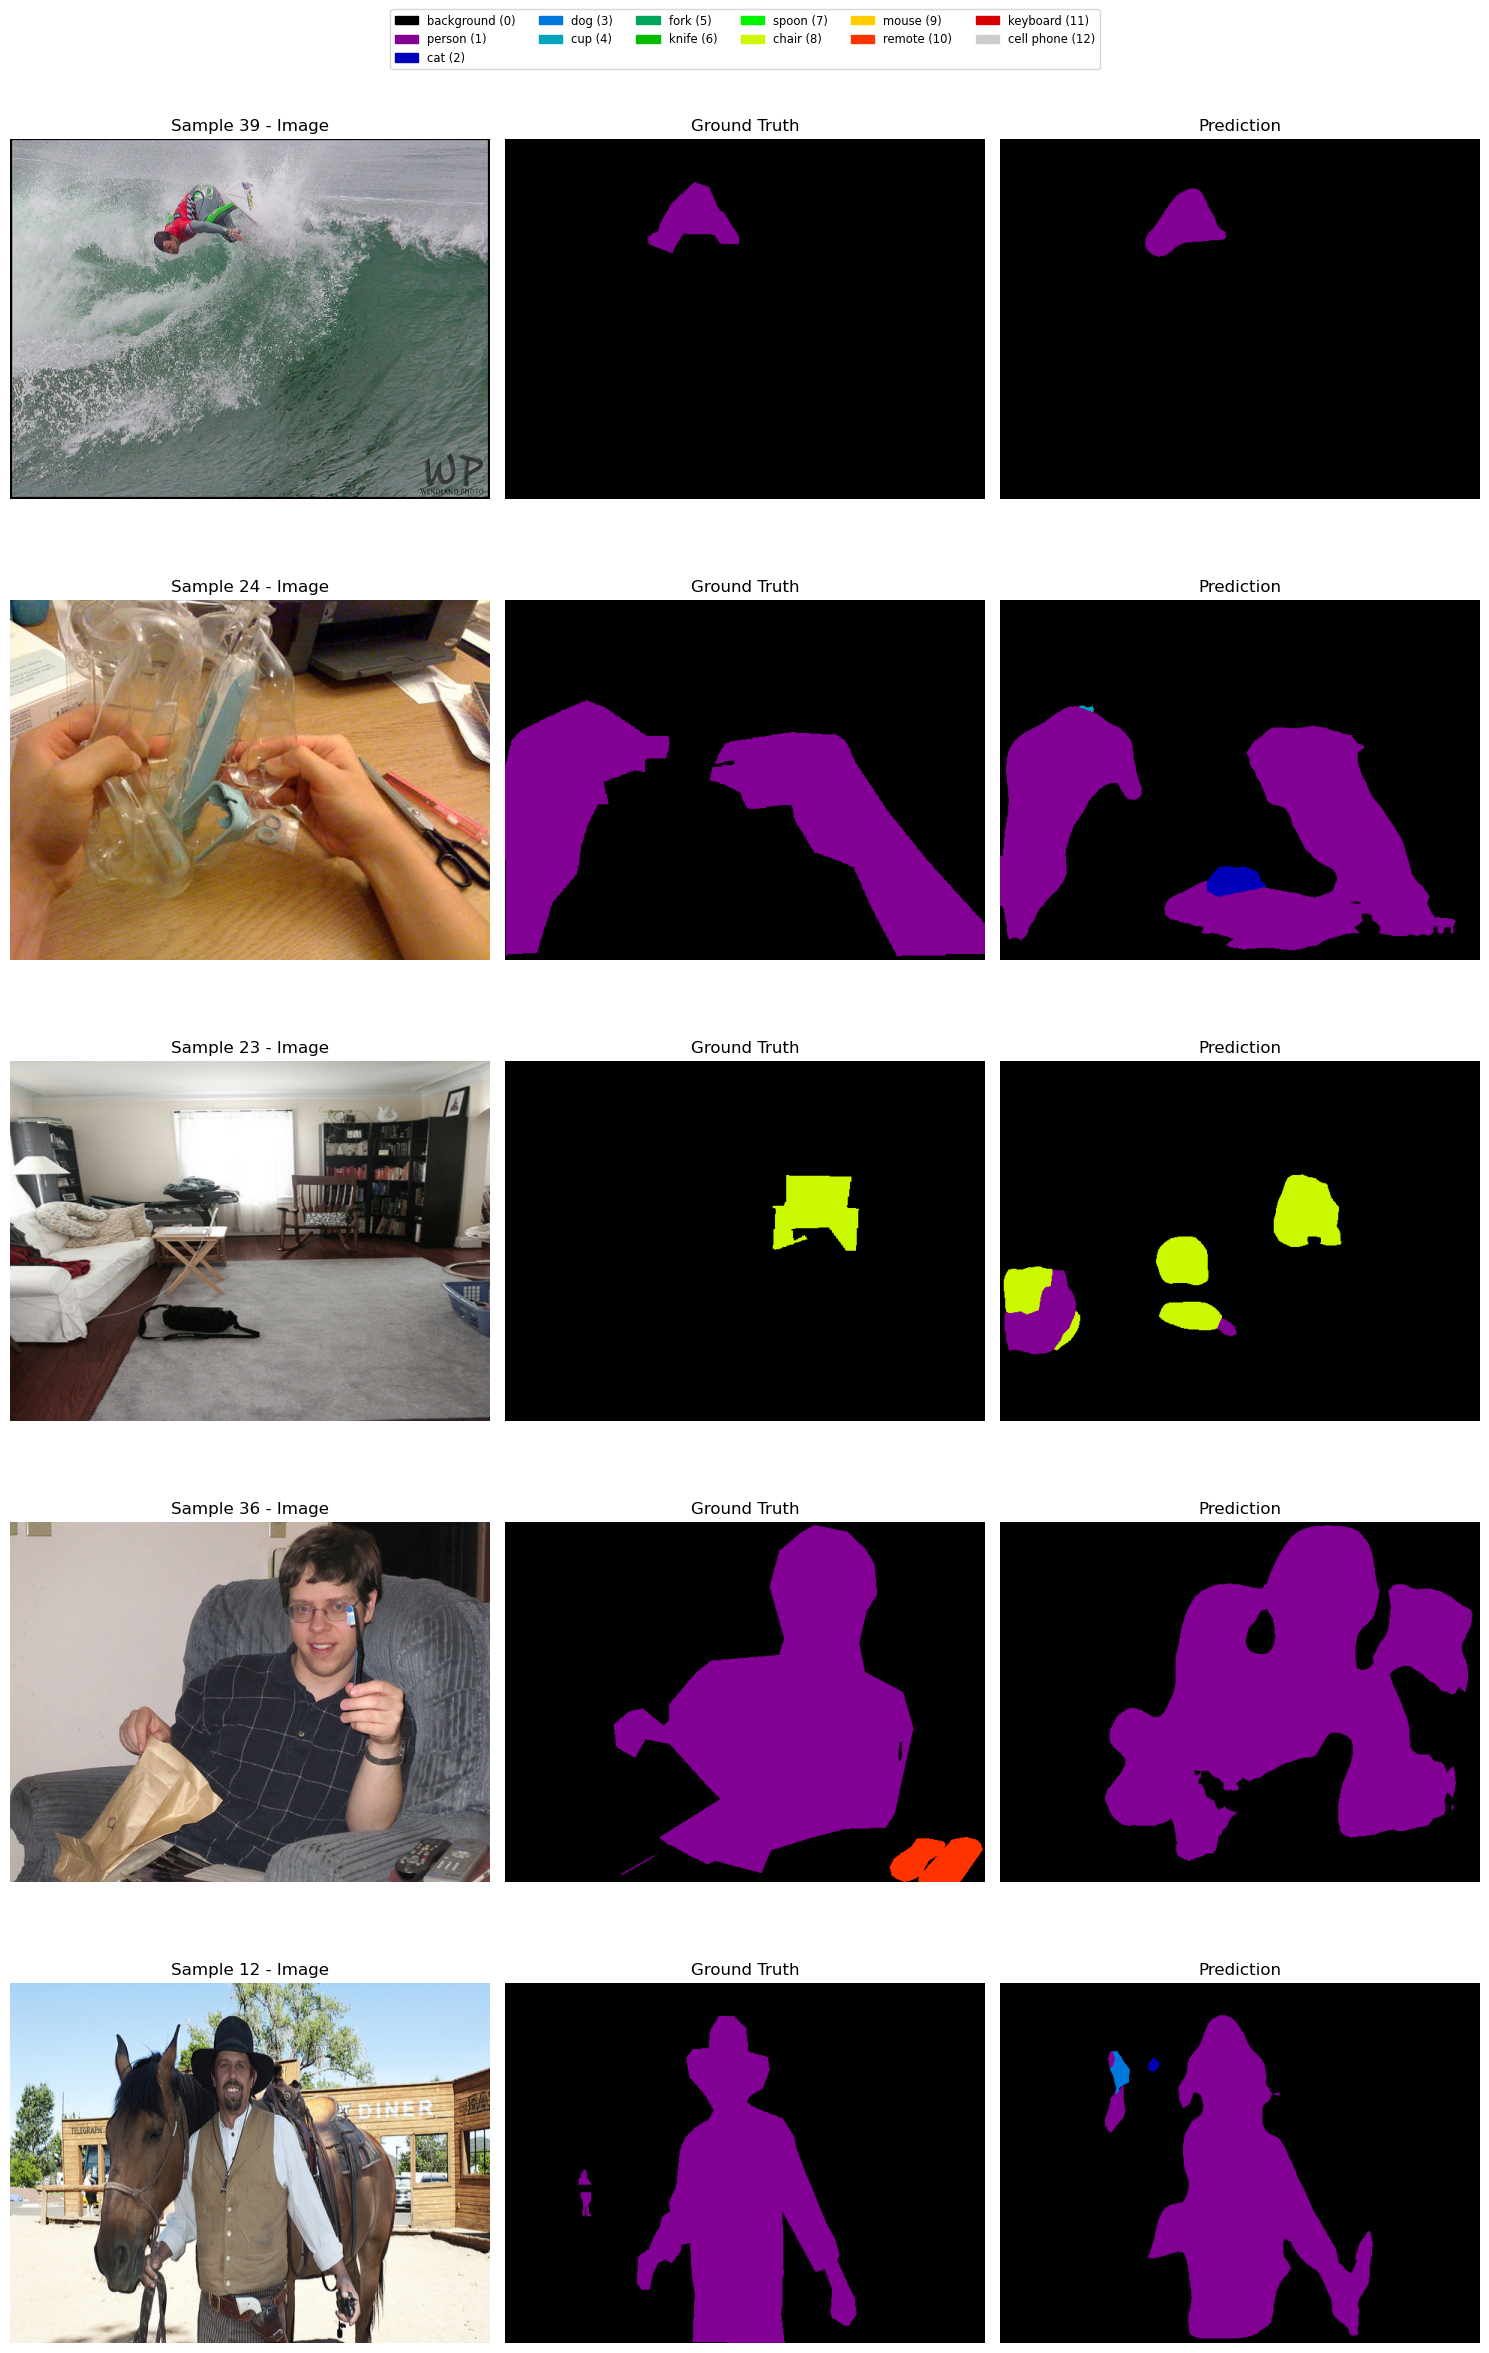

In [16]:
visualize_random_samples(saved_model, test_dataset, test_dataset.class_names, 5)